In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

!pip install --upgrade scipy==1.2.1 # to fix import imresize error in keras-vis library
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade   # Load Keras-vis library

import os
from keras.utils import to_categorical
from keras.layers import Input,Dense,Flatten,Dropout,merge,Conv2D,MaxPooling2D,Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential,load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

from keras import activations
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam

import numpy as np
import scipy.misc
from skimage.transform import resize
import numpy.random as rng
from PIL import Image
import nibabel as nib #reading MRI images
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import math
import glob
import time
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

Using TensorFlow backend.


In [0]:
ff = glob.glob('AD_CN_380/*')

In [0]:
images=[]
labels =[]
res=(242,242)

for f in range(len(ff)):
  a = nib.load(ff[f])
  a = a.get_data()
  a = a[:,57:80:2,:]
  a = np.nan_to_num(a)       # normalising to (0-1) and then normalising to 0 mean and 1 std
  m = np.max(a)
  mi = np.min(a)
  a = (a - mi) / (m - mi)
  a = (a - a.mean())/a.std()
  a =a.transpose(0,2,1)
  a = resize(a,res)

  for i in range(a.shape[2]):
      if('mwp1HC' in os.path.basename(ff[f])):
        images.append((a[:,:,i]))
        label=0
        labels.append(label)
      else:
        images.append((a[:,:,i]))
        label=1
        labels.append(label)
labels = np.asarray(labels)
labels = to_categorical(labels)
images = np.asarray(images)

In [0]:
images = images.reshape(-1, 242,242,1) # Reshaping input to feed into conv net

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,labels,test_size=0.2,random_state=13,stratify = labels)  #Test train split

[1. 0.]
[1. 0.]


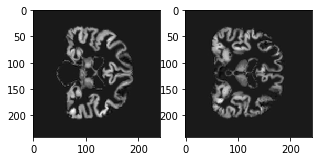

In [0]:
plt.figure(figsize=[5,5])

# Display the first image and its label in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (242,242))
plt.imshow(curr_img, cmap='gray')
print(train_ground[0])                             #Visualizing validation data
# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (242,242))
plt.imshow(curr_img, cmap='gray')
print(valid_ground[0])

In [3]:
#2D convnet
batch_size = 20 #20
epochs = 60 #60
inChannel = 1
x, y = 242, 242
input_img = Input(shape = (x, y, inChannel))


def model(input_img):
    conv1 = Conv2D(5, (3, 3), padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    relu1 = Activation('relu')(pool1)
    drop1 = Dropout(rate = 0.5)(relu1)
    conv2 = Conv2D(5, (3, 3), padding='same')(pool1) #14 x 14 x 64
   
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    pool2 = Activation('relu')(pool2)
    pool2 = Dropout(rate=0.5)(pool2)
    pool2 = Flatten()(pool2)
    dense = Dense(2, activation='softmax')(pool2) # 28 x 28 x 1
    return dense
  
model = Model(input_img, model(input_img))

In [3]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])
#with adam optimiser lr = 0.001
model.summary()

W0710 00:07:37.189640 139738656003968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 242, 242, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 242, 242, 5)       50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 242, 242, 5)       20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 121, 121, 5)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 5)       230       
_________________________________________________________________
batch_normalization_2 (Batch (None, 121, 121, 5)       20        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 5)         0         
__________

In [1]:
%%time
model_train = model.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

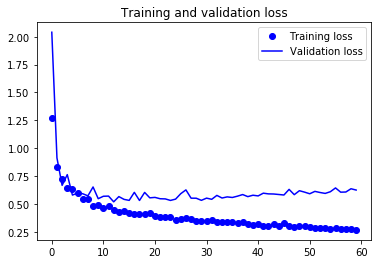

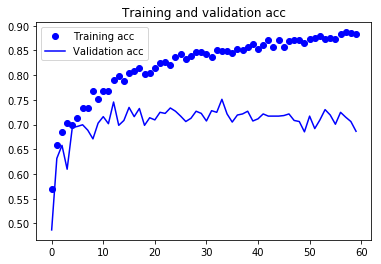

Mean training accuracy 0.820527 
Mean validation accuracy 0.705738


In [0]:
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
acc = model_train.history['acc']
val_acc = model_train.history['val_acc']
epochs = range(60)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()
acc = np.asarray(acc).mean()
val_acc = np.asarray(val_acc).mean() 
print('Mean training accuracy %f ' % acc)
print('Mean validation accuracy %f' % val_acc)

In [0]:
#save and load model

#model = model.save_weights('weight_july_8_2Dsingle.h5')
#model = Model(input_img, model(input_img))
model.load_weights('weight_july_8_2Dsingle.h5')

In [2]:
pred = model.predict(valid_X)

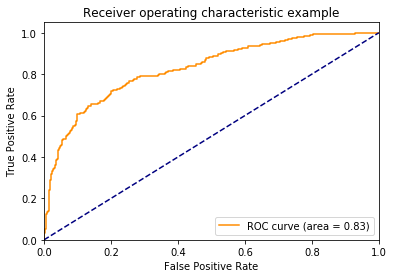

In [0]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(valid_ground[:, i], pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valid_ground.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
# Creting a custom colormap
# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('seismic')
colors_AD = cmap(np.linspace(0.5, 1, cmap.N ))
# Create a new colormap from those colors
cmap_AD = LinearSegmentedColormap.from_list('Upper Half', colors_AD)

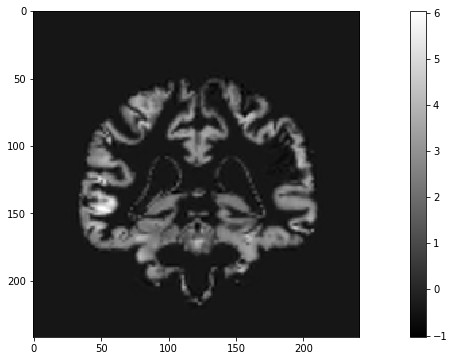

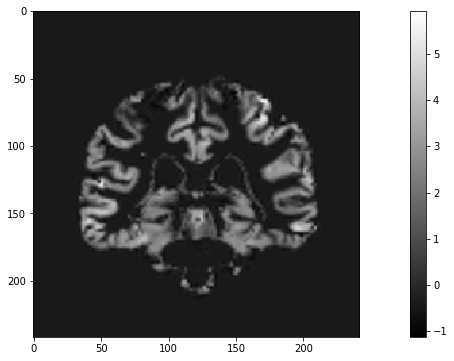

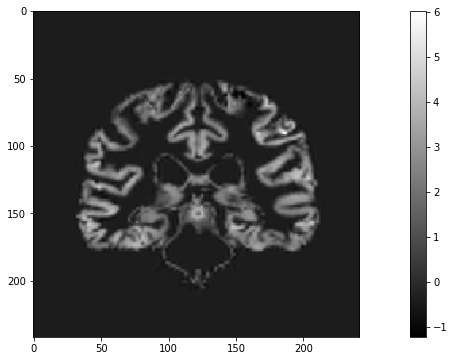

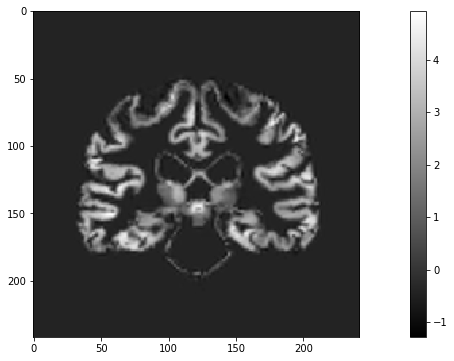

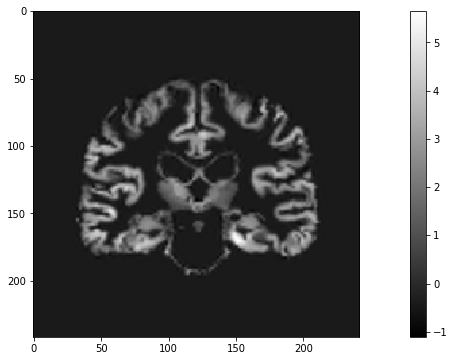

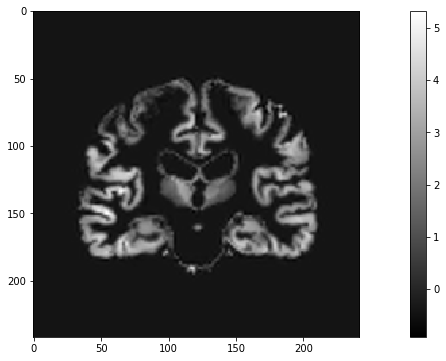

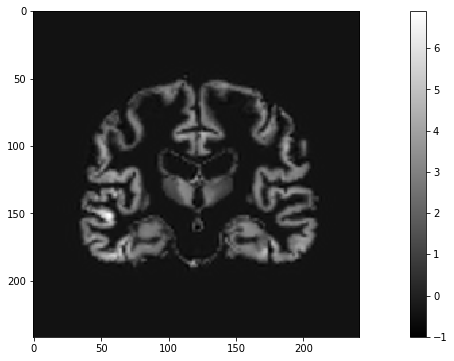

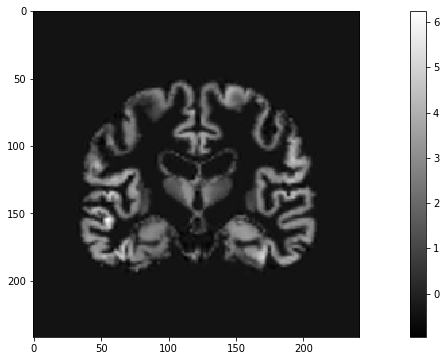

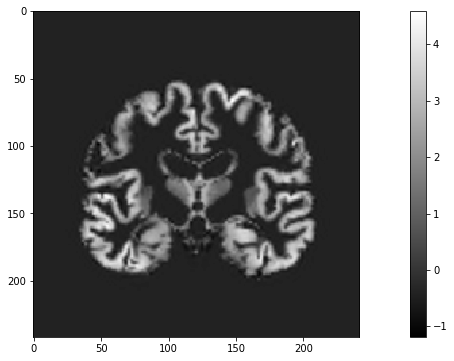

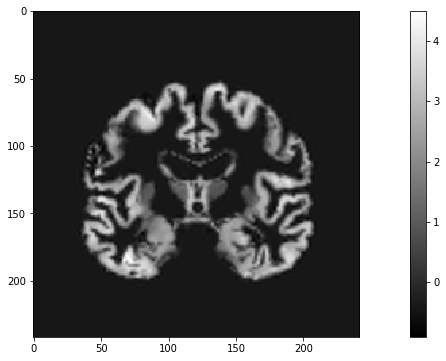

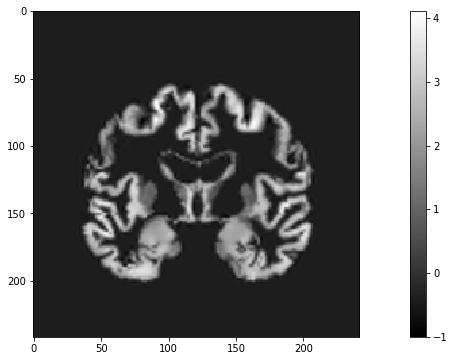

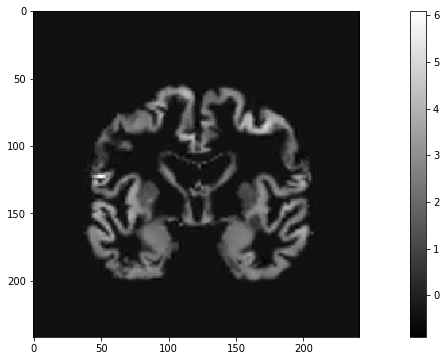

In [55]:
# Input Test image for visualization

plt.rcParams['figure.figsize'] = (18, 6)
ff_t = glob.glob('test_18/*')
test_img = nib.load(ff_t[4])
test_img = test_img.get_data()
test_img = test_img[:,57:80:2,:]
test_img = np.nan_to_num(test_img)       # normalising to (0-1) and then normalising to 0 mean and 1 std
m = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (m - mi)
test_img = (test_img - test_img.mean())/test_img.std()
test_img =test_img.transpose(0,2,1)
test_img = resize(test_img,(242,242))
coronal_slices = len(test_img[2,0])
for i in range(coronal_slices):
  plt.figure()
  a = 0
  a = test_img[:,:,i]
  a = np.rot90(a)
  a = np.fliplr(a)
  plt.imshow(a, cmap='gray')
  

In [0]:
layer_idx = utils.find_layer_idx(model, 'dense_1')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

#To visualize activation over final dense layer outputs,we need to switch the softmax activation out for linear,
#since gradient of output node will depend on all the other node activations https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb

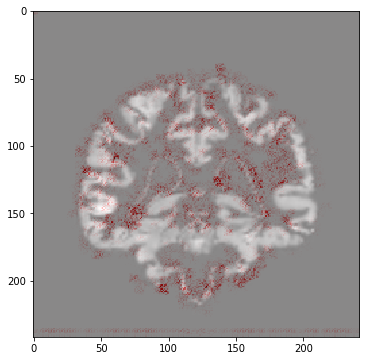

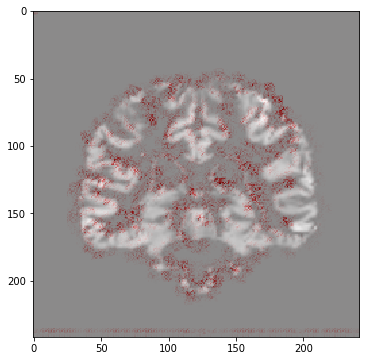

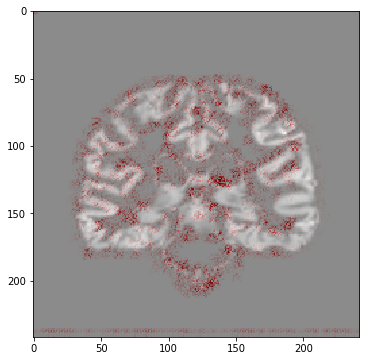

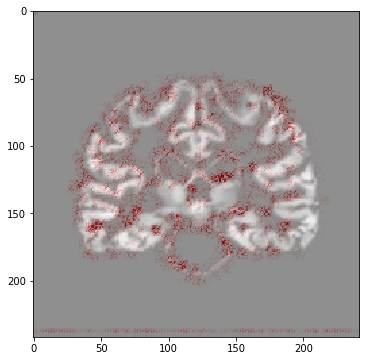

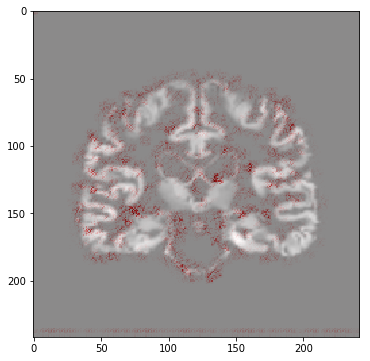

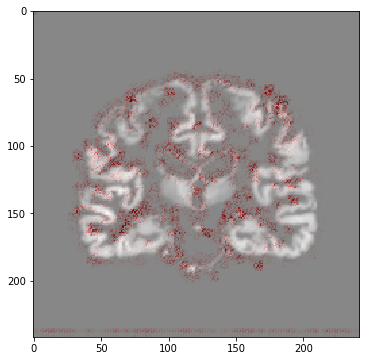

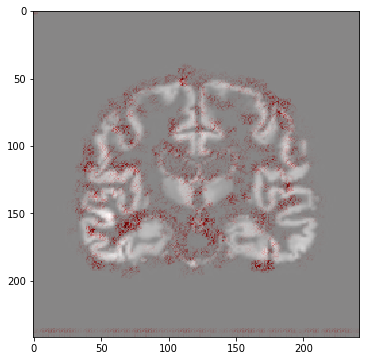

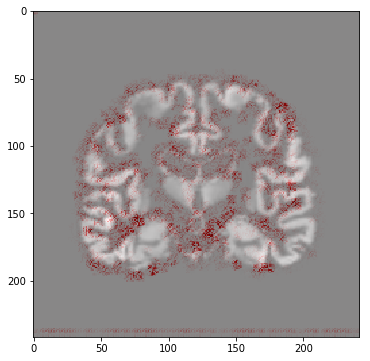

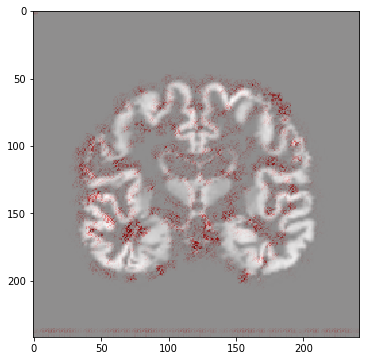

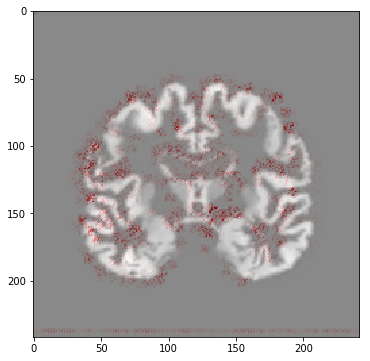

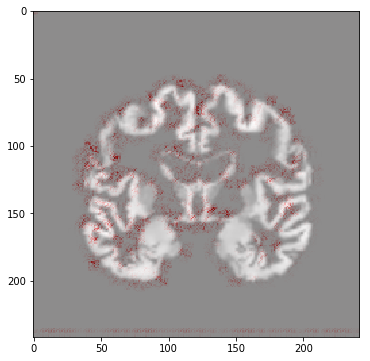

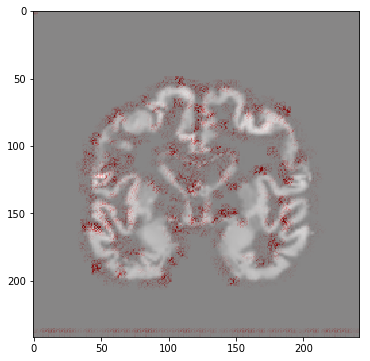

In [0]:
#saliency maps

for i in range(coronal_slices):
  plt.figure()
  a = 0
  a = test_img[:,:,i]
  a = np.rot90(a)
  a = np.fliplr(a)
  t_img = a.reshape(242,242,1)
  salient = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=t_img)
  #plt.suptitle('Sensitivity Analysis')
  plt.imshow(a, cmap='gray')
  plt.imshow(salient,cmap=cmap_AD,alpha = 0.5,vmin=0,vmax=1)
  plt.savefig("Appendix/Sal_HC_4164_" + str(i) + ".png")
  #plt.colorbar()


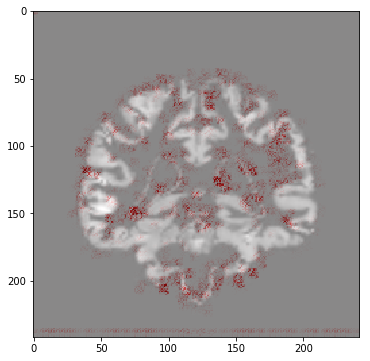

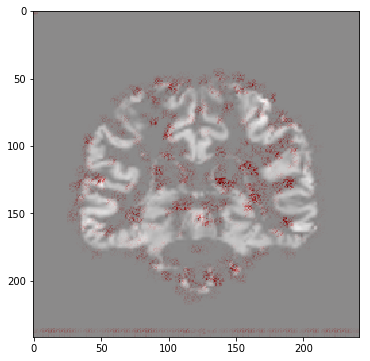

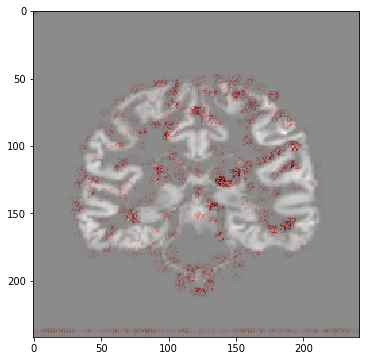

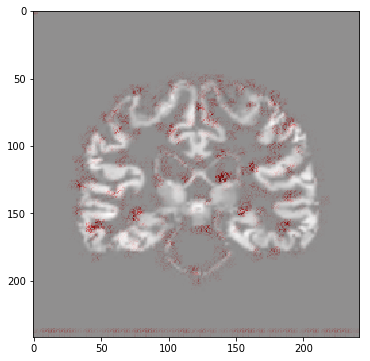

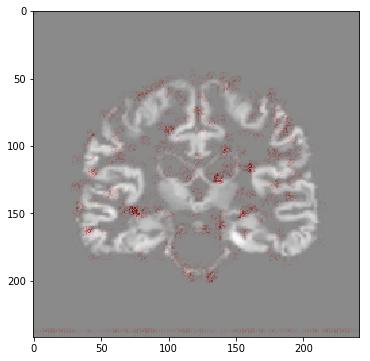

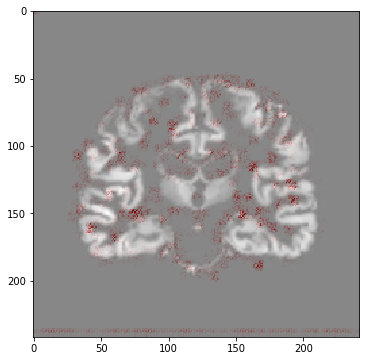

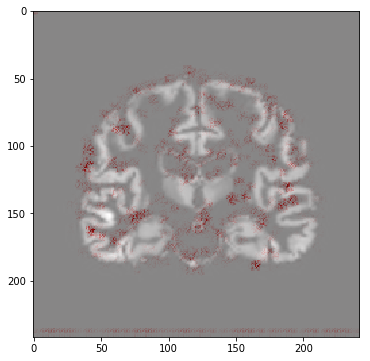

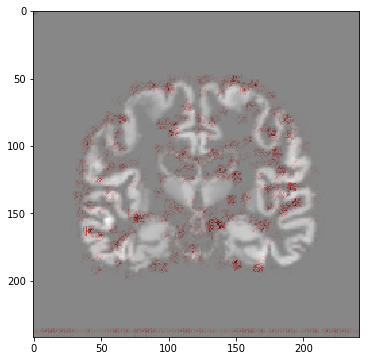

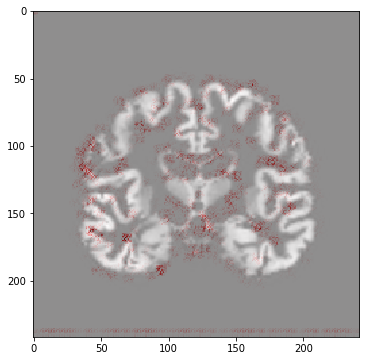

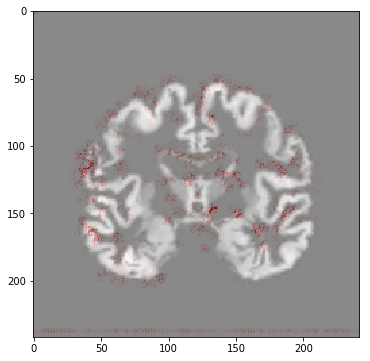

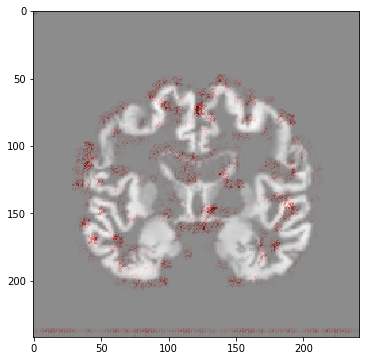

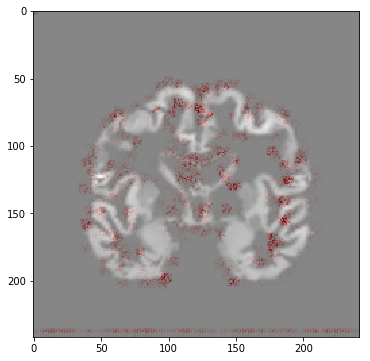

In [0]:
# guided back propogation
for i in range(coronal_slices):
  plt.figure()
  #plt.suptitle('Guided Backpropagation')
  a = 0
  a = test_img[:,:,i]
  a = np.rot90(a)
  a = np.fliplr(a)
  t_img = a.reshape(242,242,1)
  guided = visualize_saliency(model, layer_idx, filter_indices=0,seed_input=t_img, backprop_modifier='guided')
  plt.imshow(a, cmap='gray')
  plt.imshow(guided,cmap=cmap_AD,alpha = 0.5,vmin=0,vmax=1)
  #plt.colorbar()


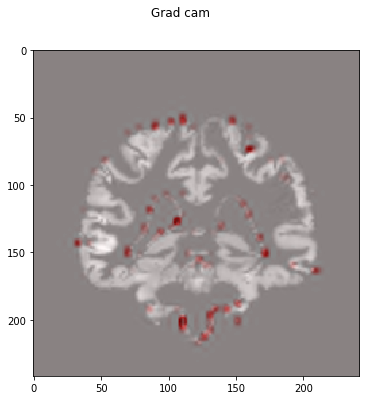

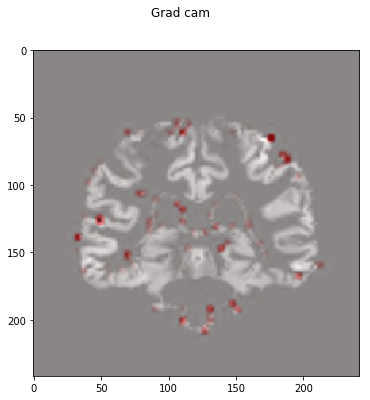

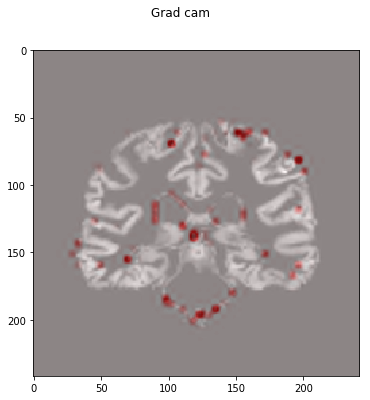

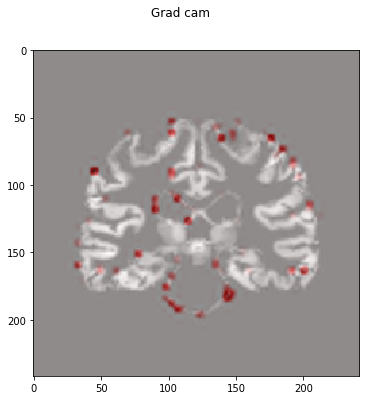

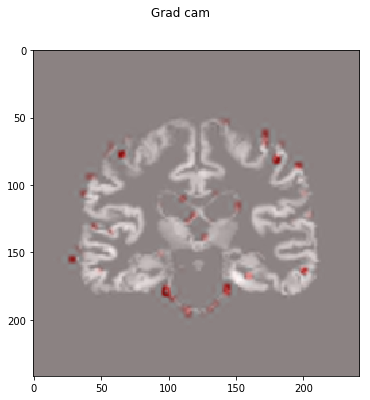

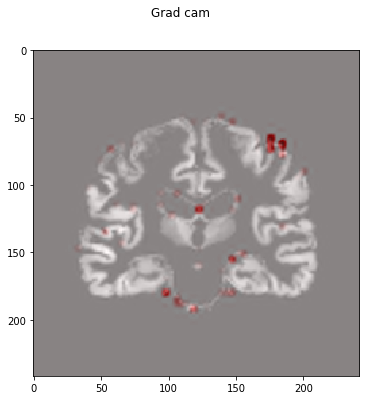

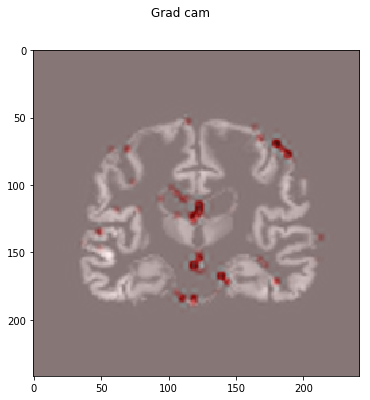

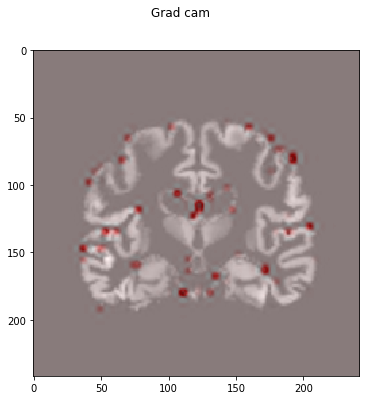

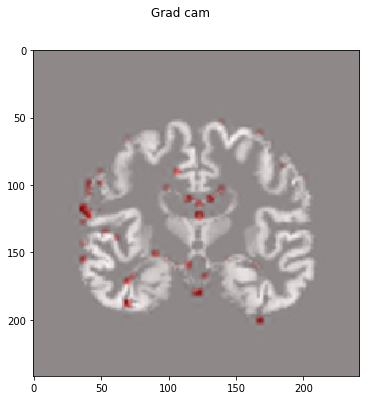

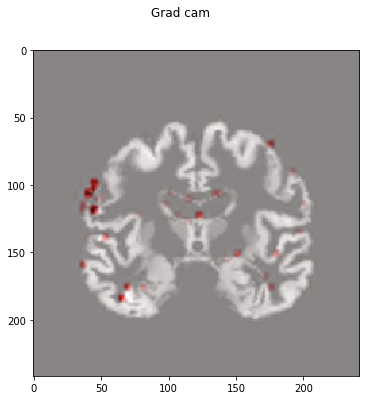

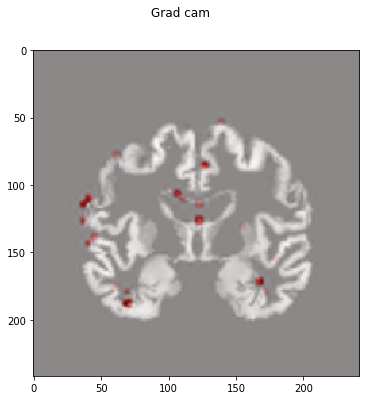

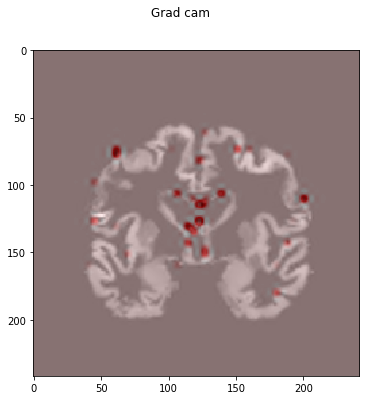

In [0]:
#Grad-CAM

for i in range(coronal_slices):
  plt.figure()
  plt.suptitle("Grad cam")
  #a = 0
  a = test_img[:,:,i]
  a = np.rot90(a)
  a = np.fliplr(a)
  t_img = a.reshape(242,242,1)
  gradcam = visualize_cam(model, layer_idx, filter_indices=0,seed_input=t_img, backprop_modifier='guided') 
  plt.imshow(a, cmap='gray')
  plt.imshow(gradcam,cmap=cmap_AD,alpha = 0.5,vmin=0.1,vmax=1)
